<a href="https://colab.research.google.com/github/jesminmousumy/Python-Programming/blob/main/Delivery_Improvement_Operation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import some libraries
import pandas as pd

data =pd.read_csv('logistics_data.csv')
print(data.head())

   Order_ID Vehicle_ID Delivery_Location  Distance  Delivery_Time     Status  \
0         1         V1        Location_A         5            1.2  Completed   
1         2         V2        Location_B         6            1.4     Failed   
2         3         V3        Location_C         7            1.6  Completed   
3         4         V4        Location_D         8            1.2  Completed   
4         5         V5        Location_E         9            1.4     Failed   

            Time_Stamp  
0  2024-12-01 00:00:00  
1  2024-12-01 01:00:00  
2  2024-12-01 02:00:00  
3  2024-12-01 03:00:00  
4  2024-12-01 04:00:00  


In [ ]:
print(data.isnull().sum())   #missing values

data_clean = data.dropna(subset=['Distance','Delivery_Time','Status'])
data_clean = data_clean[data_clean['Status'] != 'Failed']

data_clean['Time_Stamp'] = pd.to_datetime(data_clean['Time_Stamp'])

print(data_clean.head())



Order_ID             0
Vehicle_ID           0
Delivery_Location    0
Distance             0
Delivery_Time        0
Status               0
Time_Stamp           0
dtype: int64
   Order_ID Vehicle_ID Delivery_Location  Distance  Delivery_Time     Status  \
0         1         V1        Location_A         5            1.2  Completed   
2         3         V3        Location_C         7            1.6  Completed   
3         4         V4        Location_D         8            1.2  Completed   
5         6         V1        Location_F        10            1.6  Completed   
7         8         V3        Location_H        12            1.4  Completed   

           Time_Stamp  
0 2024-12-01 00:00:00  
2 2024-12-01 02:00:00  
3 2024-12-01 03:00:00  
5 2024-12-01 05:00:00  
7 2024-12-01 07:00:00  


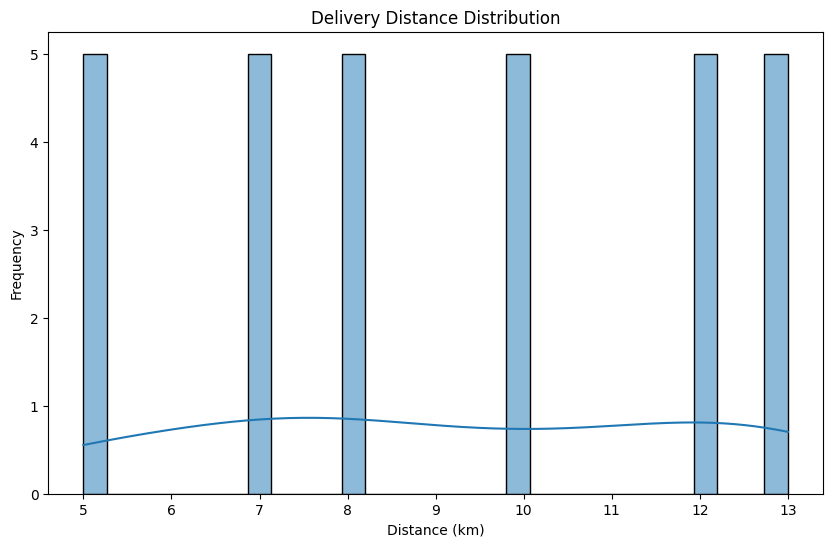

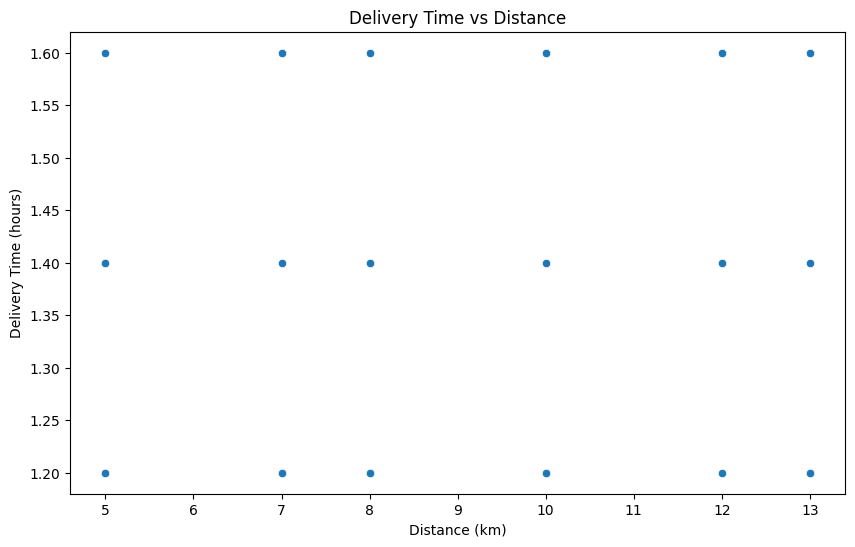

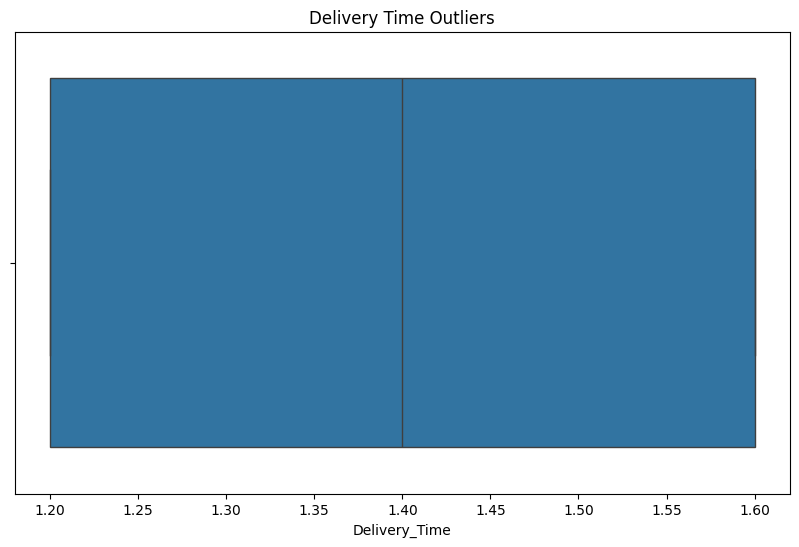

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Visulizing the distributation of delivery distances
plt.figure(figsize=(10,6))
sns.histplot(data_clean['Distance'],kde=True,bins=30)
plt.title("Delivery Distance Distribution")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

#Relationships between distance and delivery time
plt.figure(figsize=(10,6))
sns.scatterplot(x=data_clean['Distance'],y=data_clean['Delivery_Time'])
plt.title("Delivery Time vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (hours)")
plt.show()

#Checking for outliers in delivery time
plt.figure(figsize=(10,6))
sns.boxplot(x=data_clean['Delivery_Time'])
plt.title("Delivery Time Outliers")
plt.show()



  Vehicle_ID  avg_delivery_time  total_distance
1         V3               1.42              95
0         V1               1.38              75
2         V4               1.38             105


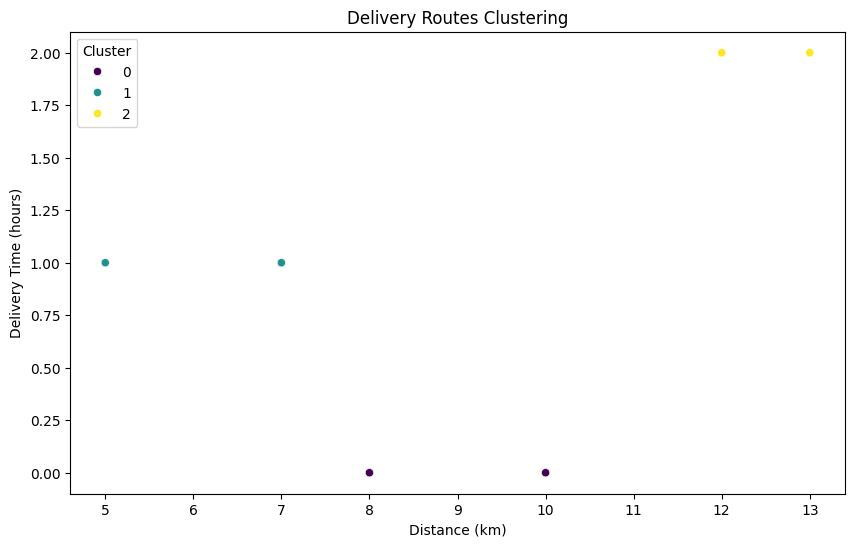

In [ ]:
#Grouping by vehicle to find delivery time performance
vehicle_performance = data_clean.groupby('Vehicle_ID').agg(
    avg_delivery_time=('Delivery_Time','mean'),
    total_distance=('Distance','sum')
).reset_index()



#Sorting vehicles by their performance
vehicle_performance_sorted = vehicle_performance.sort_values(by='avg_delivery_time',ascending=False)
print(vehicle_performance_sorted)

#Clustering delivery addresses by geographical location
from sklearn.cluster import KMeans


k_means = KMeans(n_clusters=3)
data_clean['Cluster'] = k_means.fit_predict(data_clean[['Distance']])

#Visualizing the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=data_clean['Distance'],y=data_clean['Cluster'],hue=data_clean['Cluster'],palette='viridis')
plt.title("Delivery Routes Clustering")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (hours)")
plt.show()





In [ ]:
!pip install ortools

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp #OR-tools(operations Research Tools):Solving optimization problems


#Sample coordinates for the delivery locations
coordinates =[(0,0),(1,2),(2,4),(3,5),(4,6)]

#Create the distance matrix
def compute_euclidean_distance_matrix(locations):
    size = len(locations)
    dist_matrix = {}
    for from_node in range(size):
          dist_matrix [from_node] = {}
          for to_node in range(size):
              if from_node != to_node:
                  dist_matrix[from_node][to_node] = ((locations[from_node][0] - locations[to_node][0]) **2 + (locations[from_node][1]- locations[to_node][1]) **2)**0.5 #Fixed the syntax error locations[to_node] to locations[to_node][1]
              else:
                      dist_matrix[from_node][to_node] = 0
    return dist_matrix

distance_matrix = compute_euclidean_distance_matrix(coordinates)

# Create routing model:
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def main(): # Fixed indentation here
    data = create_data_model()

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),data['num_vehicles'],data['depot'])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index,to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # The method name is changed in newer versions of ortools
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index) # Changed to SetArcCostEvaluatorOfAllVehicles

    search_parameters = pywrapcp.DefaultRoutingSearchParameters() # Added parentheses for object instantiation
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
      print_solution(data,manager,routing,solution)

      optimized_route_distance = solution.ObjectiveValue()
      print(f"Optimized Route Distance: {optimized_route_distance} km")

    else:
      print("No solution found")

def print_solution(data,manager,routing,solution):
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index,index,0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    print('Route distance: {}' .format(route_distance))

if __name__ == '__main__':
    main()

Route for vehicle 0:
 0 -> 4 -> 3 -> 2 -> 1 -> 0

Route distance: 0
Optimized Route Distance: 0 km
